In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal   # used for filtering (anti-alias example)

# Parameters
f_signal = 10.0      # signal frequency in Hz (the sine wave)
duration = 1.0       # seconds to simulate
high_fs = 10000      # "analog" / high-res sampling rate to simulate continuous time
t_cont = np.arange(0, duration, 1/high_fs)   # continuous-like time axis
x_cont = np.sin(2 * np.pi * f_signal * t_cont)  # "analog" sine


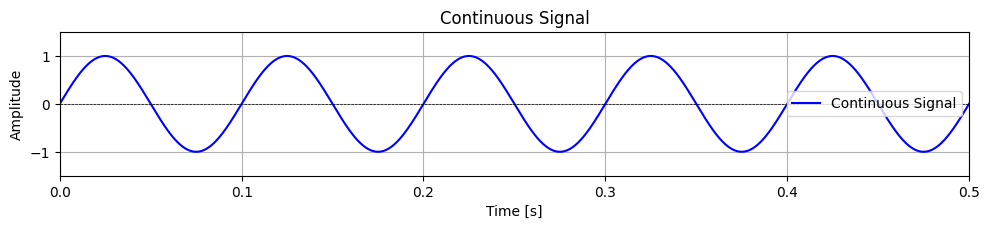

In [3]:
# Plot the continuous signal
plt.figure(figsize=(10, 6))
plt.subplot(3, 1, 1)
plt.plot(t_cont, x_cont, label='Continuous Signal', color='blue')
plt.title('Continuous Signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.grid()
plt.legend()
plt.xlim(0, 0.5)
plt.ylim(-1.5, 1.5)
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.tight_layout()
plt.show()

In [2]:
def take_samples_from_continuous(t_cont, x_cont, fs):
    T = 1.0 / fs
    t_s = np.arange(0, duration, T)            # sample times
    # get sample values by interpolation from the high-res continuous signal
    x_s = np.interp(t_s, t_cont, x_cont)
    return t_s, x_s

# quick example:
fs = 100
t_samples, x_samples = take_samples_from_continuous(t_cont, x_cont, fs)
print("num samples:", len(t_samples))


num samples: 100


In [4]:
# Zero-order hold (piecewise-constant)
def zoh_reconstruction(t_cont, t_samples, x_samples):
    idx = np.searchsorted(t_samples, t_cont, side='right') - 1
    idx[idx < 0] = 0
    idx[idx >= len(x_samples)] = len(x_samples) - 1
    return x_samples[idx]

# Linear interpolation
def linear_reconstruction(t_cont, t_samples, x_samples):
    return np.interp(t_cont, t_samples, x_samples)

# Ideal sinc reconstruction (direct - simple, easy to understand)
def sinc_reconstruction_direct(t_cont, t_samples, x_samples, T):
    # caution: builds a (len(t_cont) x len(t_samples)) matrix - OK for moderate sizes
    tau = (t_cont[:, None] - t_samples[None, :]) / T
    return np.dot(np.sinc(tau), x_samples)


In [5]:
def rmse(a, b):
    return np.sqrt(np.mean((a - b)**2))


In [6]:
def sampled_impulse_spectrum(x_samples, t_samples, t_cont, high_fs, Nfft=32768):
    # Place sample values as impulses on the high-res time grid
    sampled_on_high = np.zeros_like(t_cont)
    indices = (np.round(t_samples * high_fs)).astype(int)
    indices = np.clip(indices, 0, len(t_cont)-1)
    sampled_on_high[indices] = x_samples
    # FFT and frequency axis
    Y = np.fft.fft(sampled_on_high, n=Nfft)
    Y_shift = np.fft.fftshift(Y)
    freqs = np.fft.fftshift(np.fft.fftfreq(Nfft, d=1/high_fs))
    return freqs, np.abs(Y_shift), sampled_on_high


fs=100 Hz: samples=100  RMSE ZOH=2.5211e-01  linear=4.1441e-02  sinc=7.7443e-03


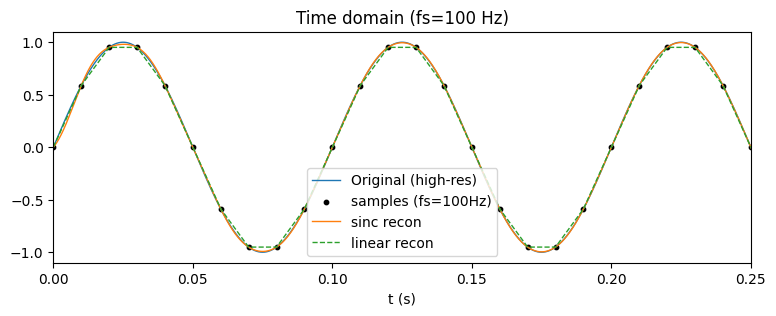

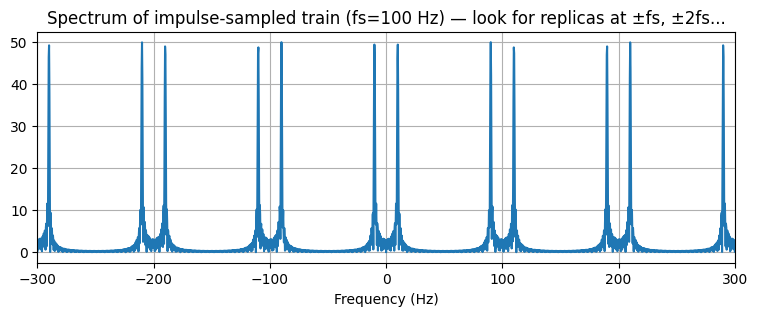

****************************************
fs=200 Hz: samples=200  RMSE ZOH=1.2602e-01  linear=1.3891e-02  sinc=2.6757e-03


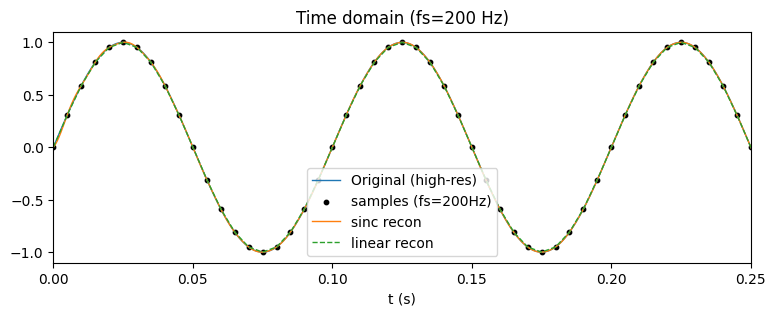

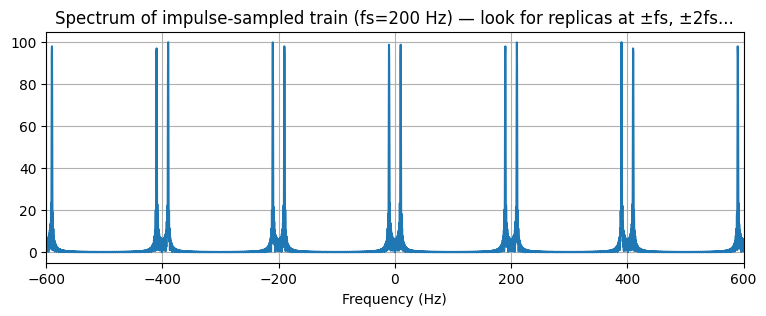

****************************************
fs=800 Hz: samples=800  RMSE ZOH=3.1096e-02  linear=1.5567e-03  sinc=3.3025e-04


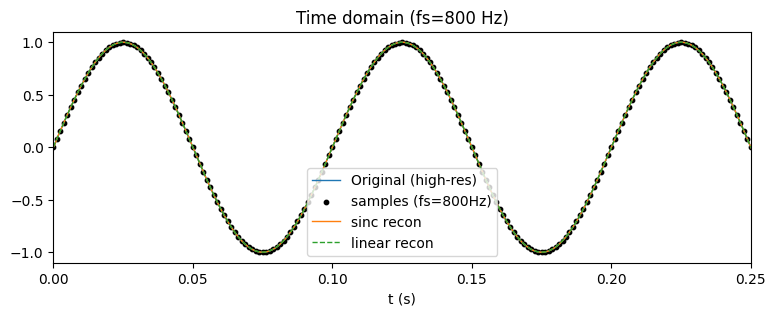

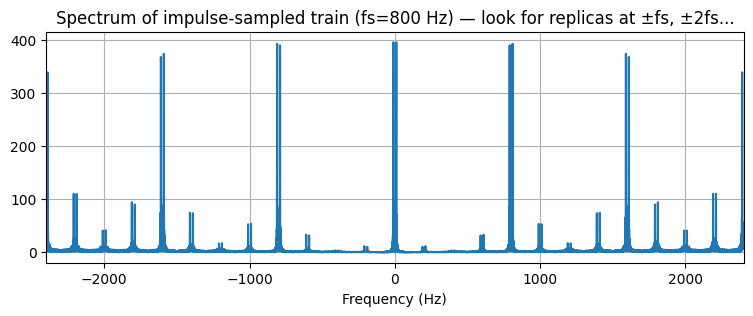

****************************************


In [8]:
sample_rates = [100, 200, 800]   # the three fs values you asked for
results = []

for fs in sample_rates:
    T = 1.0 / fs
    t_s, x_s = take_samples_from_continuous(t_cont, x_cont, fs)

    # reconstructions
    x_zoh = zoh_reconstruction(t_cont, t_s, x_s)
    x_lin = linear_reconstruction(t_cont, t_s, x_s)
    x_sinc = sinc_reconstruction_direct(t_cont, t_s, x_s, T)

    # errors
    e_zoh = rmse(x_cont, x_zoh)
    e_lin = rmse(x_cont, x_lin)
    e_sinc = rmse(x_cont, x_sinc)
    results.append((fs, len(t_s), e_zoh, e_lin, e_sinc))
    print(f"fs={fs} Hz: samples={len(t_s)}  RMSE ZOH={e_zoh:.4e}  linear={e_lin:.4e}  sinc={e_sinc:.4e}")

    # time-domain plot (zoom)
    plt.figure(figsize=(9,3))
    plt.plot(t_cont, x_cont, label='Original (high-res)', linewidth=1)
    plt.scatter(t_s, x_s, color='k', s=10, label=f'samples (fs={fs}Hz)')
    plt.plot(t_cont, x_sinc, label='sinc recon', linewidth=1)
    plt.plot(t_cont, x_lin, linestyle='--', label='linear recon', linewidth=1)
    plt.xlim(0, 0.25)
    plt.legend()
    plt.title(f"Time domain (fs={fs} Hz)")
    plt.xlabel("t (s)")
    plt.show()

    # spectrum around DC ± 3*fs (to show replicas)
    freqs, mag, sampled_on_high = sampled_impulse_spectrum(x_s, t_s, t_cont, high_fs)
    mask = (freqs >= -3*fs) & (freqs <= 3*fs)
    plt.figure(figsize=(9,3))
    plt.plot(freqs[mask], mag[mask])
    plt.title(f"Spectrum of impulse-sampled train (fs={fs} Hz) — look for replicas at ±fs, ±2fs...")
    plt.xlabel("Frequency (Hz)")
    plt.xlim(-3*fs, 3*fs)
    plt.grid(True)
    plt.show()
    print("*"*40)
    


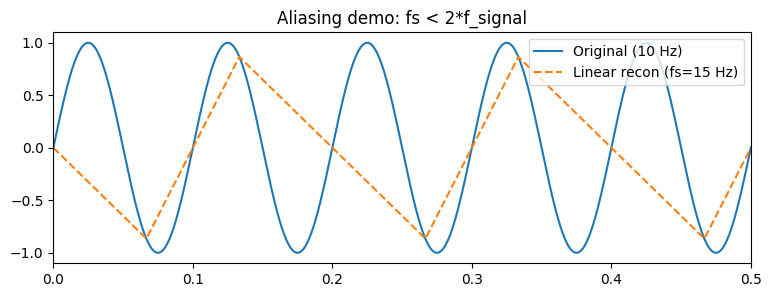

In [9]:
fs_alias = 15  # lower than 2*f_signal=20 -> aliasing expected
t_s_a, x_s_a = take_samples_from_continuous(t_cont, x_cont, fs_alias)
# reconstruct with linear and plot (sinc will "reconstruct" the aliased signal)
x_lin_alias = linear_reconstruction(t_cont, t_s_a, x_s_a)

plt.figure(figsize=(9,3))
plt.plot(t_cont, x_cont, label='Original (10 Hz)')
plt.plot(t_cont, x_lin_alias, label=f'Linear recon (fs={fs_alias} Hz)', linestyle='--')
plt.xlim(0, 0.5)
plt.legend()
plt.title("Aliasing demo: fs < 2*f_signal")
plt.show()


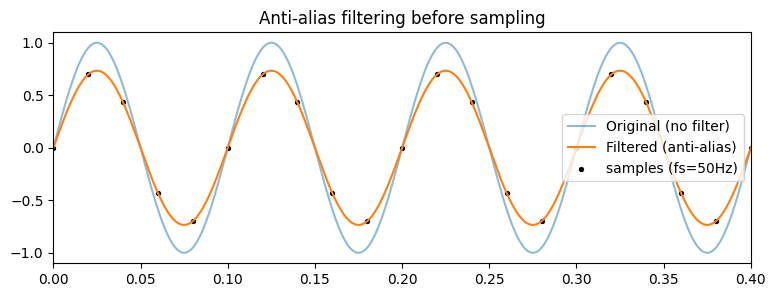

In [10]:
def lowpass_fir_cutoff(cutoff_hz, high_fs, numtaps=513):
    # design an FIR using scipy.signal.firwin with specified cutoff (Hz) and sampling rate high_fs
    h = signal.firwin(numtaps, cutoff_hz, fs=high_fs, window='hann')
    return h

# Example: cutoff halfway to Nyquist of the target sample rate (safety)
target_fs = 50            # pretend we want to sample later at 50 Hz
cutoff = 0.45 * (target_fs / 2.0)  # conservative cutoff (Hz)
h = lowpass_fir_cutoff(cutoff, high_fs, numtaps=513)
# apply zero-phase filtering for minimal phase distortion
x_filt = signal.filtfilt(h, [1.0], x_cont)

# now sample the filtered signal at target_fs and compare
t_s2, x_s2 = take_samples_from_continuous(t_cont, x_filt, target_fs)
x_lin2 = linear_reconstruction(t_cont, t_s2, x_s2)

plt.figure(figsize=(9,3))
plt.plot(t_cont, x_cont, alpha=0.5, label='Original (no filter)')
plt.plot(t_cont, x_filt, label='Filtered (anti-alias)')
plt.scatter(t_s2, x_s2, color='k', s=8, label=f'samples (fs={target_fs}Hz)')
plt.xlim(0, 0.4)
plt.legend()
plt.title("Anti-alias filtering before sampling")
plt.show()
